In [1]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(clustAnalytics)
library(rlist)
library(ggdensity)
library(ggsci)
library(stringr)
library(corrplot)
library(RColorBrewer)
library(VennDiagram)
library(ggpubr)
library(reshape2)
library(pheatmap)
library(ComplexHeatmap)
library(latex2exp)


options(bitmapType = 'cairo')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following obje

In [2]:
setwd('/scratch/tmp/dolgalev/castom-igex-revision/epixcan/')

In [3]:
outFold <- sprintf('/scratch/tmp/dolgalev/castom-igex-revision/results/epixcan/graphs')
colorFile <- sprintf('~/tools/castom_cad_scz/jupyter_notebook/color_pheno_type_UKBB.txt')

In [3]:
fold_tissue <- "results/ukbb/CAD_HARD_clustering/update_corrPCs"
out_tissue <- get(load(sprintf('%s/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', fold_tissue)))
path_tissue <- get(load(sprintf('%s/pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', fold_tissue)))
endop_tissue <- read_tsv(sprintf('%s/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_combined_keepPhenoClass.txt', fold_tissue), show_col_types = FALSE)

fold_priler <- "data/CASTom-iGEx_output/CAD_Liver"
out_priler <- get(load(sprintf('%s/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', fold_priler)))
path_priler <- get(load(sprintf('%s/pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', fold_priler)))
endop_priler <- read_tsv(sprintf('%s/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_combined_keepPhenoClass.txt', fold_priler), show_col_types = FALSE)

In [4]:
plot_overlap_clusters <- function(cl_PRS, cl_tissue, tissue_name, PRS_name, width_pl = 6, height_pl = 6, outFold){
    
    NMI_res <- compare(cl_PRS$cl_best$gr, cl_tissue$cl_best$gr, method = "NMI")
    chisq_pvalue <- chisq.test(table(cl_PRS$cl_best$gr, cl_tissue$cl_best$gr))$p.value
    
    # get enrichment
    tab_ov <- table(cl_PRS$cl_best$gr, cl_tissue$cl_best$gr)
    row_s <- rowSums(tab_ov)
    col_s <- colSums(tab_ov)
    exp_ov <- (row_s %o% col_s) / sum(tab_ov)
  
    tmp1 <- as.data.frame(tab_ov) #(tab_ov - exp_ov)/exp_ov)
    tmp1 <- dcast(tmp1, Var1 ~ Var2, value.var = "Freq")
    tmp1 <- tmp1 %>% select(-Var1)
    colnames(tmp1) <- paste0(tissue_name,' gr', colnames(tmp1))
    rownames(tmp1) <- paste0(PRS_name , ' gr', rownames(tmp1))
    tmp1 <- as.matrix(tmp1)
  
    tmp2 <- as.data.frame((tab_ov - exp_ov)/exp_ov)
    tmp2 <- dcast(tmp2, Var1 ~ Var2, value.var = "Freq")
    tmp2 <- tmp2 %>% select(-Var1)
    colnames(tmp2) <- paste0(tissue_name,' gr', colnames(tmp2))
    rownames(tmp2) <- paste0(PRS_name , ' gr', rownames(tmp2))
    tmp2 <- as.matrix(tmp2)


  pdf(file = sprintf('%sconttable_%s_vs_%s_clusters.pdf', outFold, PRS_name, tissue_name), 
    width = width_pl, height = height_pl, compress = F, pointsize = 12)

   corrplot(tmp1, 
        method = 'color',
        tl.col = "black", # text color
          col.lim = c(0, 7000),
            cl.length = 8,
         tl.cex=1.2,
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))
    dev.off()
  
  pdf(file = sprintf('%sconttable_enrichment_%s_vs_%s_clusters.pdf', outFold, PRS_name, tissue_name), 
    width = width_pl, height = height_pl, compress = F, pointsize = 12)
  corrplot(tmp2, 
        method = 'color',
        tl.col = "black", # text color
            cl.length = 8,
         tl.cex=1.2,
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))
    dev.off()
  
    return(list(NMI = NMI_res, chisq_pvalue = chisq_pvalue, chisq_enrich = tmp1))

}


plot_intersection_endop <- function(
  tissue, 
  PRS, 
  outFold, 
  pval_corr_thr = 0.05, 
  name_PRS,
  name_tissue,
  width_pl = 5, 
  height_pl = 5){
        

  common_pheno <- intersect(unique(tissue$pheno_id), unique(PRS$pheno_id))
  un_p <- setdiff(unique(tissue$pheno_id), common_pheno)
  tissue_unique = tissue[tissue$pheno_id %in% un_p,]
  print(table(tissue_unique[!duplicated(tissue_unique$pheno_id),"pheno_type"]))

  comp_tissue <- sort(unique(tissue$comp))
  comp_PRS <- sort(unique(PRS$comp))

        pheno_sign_tissue <- tissue %>%
        mutate(type = name_tissue) %>%
        mutate(comp_type = paste0(name_tissue, " gr", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr) 

        pheno_sign_PRS <- PRS %>%
        mutate(type = name_PRS) %>%
        mutate(comp_type = paste0(name_PRS, " gr", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr) 

        futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
        tmp <- venn.diagram(list(EpiXcan = unique(pheno_sign_tissue$pheno_id), PriLer = unique(pheno_sign_PRS$pheno_id)), 
        fill = c("red", "blue"),
        alpha = c(0.5, 0.5), 
        lty = 2,
        filename = NULL, 
        lwd = 1,
        cex = 2,
        cat.cex = 2)
        grid.draw(tmp)

        pdf(file = sprintf('%sVenn_signEndopheno_%s_%s.pdf', outFold, name_tissue, name_PRS),  width = 4, height = 3)
        grid.draw(tmp)
        dev.off()

        common_sign_pheno <- intersect(unique(pheno_sign_tissue$pheno_id), unique(pheno_sign_PRS$pheno_id))
        tmp <- pheno_sign_tissue[pheno_sign_tissue$pheno_id %in% common_sign_pheno,]
        return(tmp[!duplicated(tmp$pheno_id), c("pheno_id", "Field", "meaning")])
  }


endopheno_forest_plot <- function(common_endo, colorFile, res_pheno, pval_pheno = 0.0001, pval_corr_thr = 0.05, outFold, type_input, type_cluster) { 

    pheno_ann <- read.delim(colorFile, header = T, stringsAsFactors = F)

    id_keep <- unique(res_pheno$pheno_id[res_pheno$pvalue <= pval_pheno | res_pheno$pval_corr <= pval_corr_thr])
    id_keep <- id_keep[!is.na(id_keep)]
    df_red <- res_pheno %>% filter(pheno_id %in% id_keep) %>% 
        mutate(new_id = case_when(Field == "Diagnoses - ICD10" & !is.na(meaning)  ~ meaning, 
                                  grep("Illnesses", Field) & !is.na(meaning) ~ paste(Field, meaning, sep = ': '), 
                                  is.na(meaning) ~ paste(Field), 
                                  TRUE ~ paste(Field, meaning, sep = '\n'))) %>%
        mutate(sign = ifelse(pval_corr <= pval_corr_thr, 'yes', 'no')) %>%
        mutate(type_res = ifelse(type_pheno == 'CONTINUOUS', 'beta', 'OR')) %>%
        mutate(OR_or_Beta = ifelse(se_beta > 100, NA, OR_or_Beta)) %>%
        mutate(CI_low = ifelse(se_beta > 100, NA, CI_low)) %>% 
        mutate(CI_up = ifelse(se_beta > 100, NA, CI_up))
  
    df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
    df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
    df_red$pheno_type <- factor(df_red$pheno_type, levels = unique(df_red$pheno_type))
    df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))
    df_red$type_res <- factor(df_red$type_res, levels = c('OR', 'beta'))

    df_red_for_ann <- df_red[!duplicated(df_red$new_id),]
    pheno_ann_red1 <- pheno_ann[match(df_red_for_ann$pheno_type[df_red_for_ann$type_pheno != 'CONTINUOUS'], pheno_ann$pheno_type), ,drop = F]
    pheno_ann_red2 <- pheno_ann[match(df_red_for_ann$pheno_type[df_red_for_ann$type_pheno == 'CONTINUOUS'], pheno_ann$pheno_type), ,drop = F]
    pheno_ann_red1$in_common <- df_red_for_ann$pheno_id[df_red_for_ann$type_pheno != 'CONTINUOUS'] %in% common_endo$pheno_id
    pheno_ann_red1$face <- sapply(pheno_ann_red1$in_common, function(x) ifelse(x, 'bold', 'plain'))
    pheno_ann_red2$in_common <- df_red_for_ann$pheno_id[df_red_for_ann$type_pheno == 'CONTINUOUS'] %in% common_endo$pheno_id
    pheno_ann_red2$face <-  sapply(pheno_ann_red2$in_common, function(x) ifelse(x, 'bold', 'plain'))

    len_w <- length(unique(df_red$comp))
    len_h <- length(unique(df_red$pheno_id))
    # change labels 
    labs_new <- sapply(as.character(unique(df_red$comp)), function(x) strsplit(x, split = '_vs_all')[[1]][1])
    names(labs_new) <- as.character(unique(df_red$comp))
  
  P <- length(unique(df_red$comp))
  if(P > 20){
    getPalette <- colorRampPalette(pal_d3("category20")(20))
    gr_color <- getPalette(P)
  }else{
    gr_color <- pal_d3("category20")(P)
  }

    if(any(df_red$type_pheno != 'CONTINUOUS')){
    
    pl_OR <-  ggplot(subset(df_red, type_pheno != 'CONTINUOUS'), aes(x = new_id, y = OR_or_Beta, shape = sign))+
      geom_point()+geom_errorbar(aes(ymin=CI_low, ymax=CI_up), width=.2, position=position_dodge(0.05))+
      theme_bw()+ 
      ylab('Adjusted OR (95% CI)')+ geom_hline(yintercept = 1, linetype = 'dashed', color = 'grey40')+
      facet_wrap(comp~.,  nrow = 1, strip.position="top", labeller = labeller(comp = labs_new))+
      theme(legend.position = 'none', 
            plot.title = element_text(size=9), 
            axis.title.y = element_blank(), 
            axis.title.x = element_text(size=8),
            axis.text.x = element_text(size = 7, angle = 45, hjust = 1), 
            axis.text.y = element_text(size = 7, colour = pheno_ann_red1$color, face = pheno_ann_red1$face),
            strip.text = element_text(size=8, color = 'white', face = 'bold'))+
      scale_shape_manual(values=c(1, 19))+
      scale_color_manual(values=pheno_ann_red1$color)+
      scale_y_continuous(trans='log', labels = scales::number_format(accuracy = 0.01))+
      coord_flip()
    
    pl_OR <- ggplot_gtable(ggplot_build(pl_OR))
    stripr <- which(grepl('strip-t', pl_OR$layout$name))
    fills <- gr_color
    k <- 1
        for (i in stripr) {
      j <- which(grepl('rect', pl_OR$grobs[[i]]$grobs[[1]]$childrenOrder))
      pl_OR$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
      k <- k+1
    }
  }
  
  if(any(df_red$type_pheno == 'CONTINUOUS')){
    
    pl_beta <-  ggplot(subset(df_red, type_pheno == 'CONTINUOUS'), aes(x = new_id, y = OR_or_Beta, shape = sign))+
      geom_point()+geom_errorbar(aes(ymin=CI_low, ymax=CI_up), width=.2, position=position_dodge(0.05))+
      theme_bw()+ 
      ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
      facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
      theme(legend.position = 'none', 
            plot.title = element_text(size=9), 
            axis.title.y = element_blank(), 
            axis.title.x = element_text(size=8),
            axis.text.x = element_text(size = 7, angle = 45, hjust = 1), 
            axis.text.y = element_text(size = 7,  colour = pheno_ann_red2$color, face = pheno_ann_red2$face), 
            strip.text = element_text(size=8, color = 'white', face = 'bold'))+
      scale_shape_manual(values=c(1, 19))+
      scale_color_manual(values=pheno_ann_red2$color)+
      coord_flip()

    sum_c <- sum(df_red$type_pheno == 'CONTINUOUS')
    sum_notc <- sum(df_red$type_pheno != 'CONTINUOUS')

    ratio_OR_beta <- ifelse(sum_c > sum_notc, (sum_notc)/sum_c + 0.1, (sum_c)/sum_notc + 0.1)
    print(ratio_OR_beta)

    pl_beta <- ggplot_gtable(ggplot_build(pl_beta))
    stripr <- which(grepl('strip-t', pl_beta$layout$name))
    fills <- gr_color
    k <- 1
        for (i in stripr) {
      j <- which(grepl('rect', pl_beta$grobs[[i]]$grobs[[1]]$childrenOrder))
      pl_beta$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
      k <- k+1
    }
  }
  
  if(any(df_red$type_pheno == 'CONTINUOUS') & any(df_red$type_pheno != 'CONTINUOUS')){
    if(sum_c > sum_notc){
      heights_tmp = c(1, ratio_OR_beta)
    }else{
      heights_tmp = c(ratio_OR_beta, 1)
    }
    tot_pl <- ggarrange(plotlist = list(pl_beta, pl_OR), align = 'v', ncol = 1, heights = heights_tmp)
  }else{
    if(any(df_red$type_pheno == 'CONTINUOUS')){
      tot_pl <- pl_beta
    }else{
      tot_pl <- pl_OR
    }
  }
  
  ggsave(filename = sprintf('%s%s_cluster%s_phenoAssociation_GLM_betaOR_Integrated.pdf', outFold, type_input, type_cluster), 
         width = len_w*0.8+4, height = len_h*0.2+1, plot = tot_pl, device = 'pdf')

      return(tot_pl)
}
                       
plot_corr_pheno <- function(cases, controls, outFold, pval_corr_thr = 0.05, name_comp_controls = "Controls", width_pl = 5, height_pl = 5){

pheno_cases <- cases %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("EpiXcan ", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))


pheno_controls <- controls %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("PriLer ", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))

pheno_tot <- rbind(pheno_cases, pheno_controls)
comp_all <- unique(pheno_tot$comp_type)
comp_cases <- unique(pheno_cases$comp_type)
comp_controls <- unique(pheno_controls$comp_type)

cor_mat <- matrix(nrow = length(comp_cases), ncol = length(comp_controls))
colnames(cor_mat) <- comp_controls
rownames(cor_mat) <- comp_cases
pval_mat <- cor_mat

for(i in 1:length(comp_cases)){
    ci_cases <- comp_cases[i]
    vi <- pheno_tot %>% filter(comp_type == ci_cases) %>% filter(!is.na(beta))
    for(j in 1:length(comp_controls)){
        cj_controls <- comp_controls[j]
        vj <- pheno_tot %>% filter(comp_type == cj_controls) %>% filter(!is.na(beta))
        # check order is correct
        if(!identical(vi$pheno_id, vj$pheno_id)){
                p_common <- intersect(vi$pheno_id, vj$pheno_id)
                print(sprintf('N. common pheno for %s and %s = %i', ci_cases, cj_controls, length(p_common)))
                vi_new <-  vi[match(p_common, vi$pheno_id),]
                vj_new <-  vj[match(p_common, vj$pheno_id),]
        }else{
                vi_new <- vi
                vj_new <- vj
        }
        cor_mat[i,j] <- cor(vi_new$beta, vj_new$beta, method = 'pearson')
        pval_mat[i,j] <- cor.test(vi_new$beta, vj_new$beta, method = 'pearson')$p.value
    }
}


pdf(file = sprintf('%scorr_Endopheno_compare_Cases_%s.pdf', outFold, name_comp_controls), 
    width = width_pl, height = height_pl, compress = F, pointsize = 12)
    corrplot(cor_mat, 
        sig.level = 0.05, 
        p.mat = pval_mat,
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))
dev.off()

# plot NMI
corrplot(cor_mat, 
        tl.col = "black", # text color
        sig.level = 0.05, 
        p.mat = pval_mat,
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))

return(list(cor = cor_mat))

}
                       

plot_intersection <- function(
  cases, 
  controls, 
  outFold, 
  pval_corr_thr = 0.01, 
  type_data, 
  name_comp_controls = "Controls", 
  width_pl = 5, 
  height_pl = 5){

comp_cases <- sort(unique(cases$test_feat[[1]]$comp))
comp_controls <- sort(unique(controls$test_feat[[10]]$comp))

feat_sign_cases <- lapply(cases$test_feat, function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(type = "EpiXcan") %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr)) %>%
    bind_rows()


feat_sign_controls <- lapply(list(controls$test_feat[[10]]), function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(type = "PriLer") %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr)) %>%
    bind_rows() 

feat_sign_tot <- rbind(feat_sign_cases, feat_sign_controls)

common_feat <- intersect(unique(feat_sign_cases$feat_tissue), unique(feat_sign_controls$feat_tissue))

df <- feat_sign_tot %>% 
    mutate(common = case_when(feat_tissue %in% common_feat ~ 'common', TRUE ~ 'unique'))
df$common <- factor(df$common, levels = c('unique', 'common'))

futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

tmp <- venn.diagram(list(EpiXcan = unique(feat_sign_cases$feat_tissue), PriLer = unique(feat_sign_controls$feat_tissue)), 
  fill = c("red", "blue"),
  alpha = c(0.5, 0.5), 
  lty = 2,
  filename = NULL, 
  lwd = 1,
  cex = 2,
  cat.cex = 2)
pdf(file = sprintf('%sVenn_sign%s_Cases_%s.pdf', outFold, type_data, name_comp_controls), 
    width = 3, height = 3)
    grid.draw(tmp)
  dev.off()
grid.draw(tmp)

type_data_pl <- ifelse(type_data == 'Tscores', 'genes', 'pathways')
# add boxplot of estimates from df, divide per common/unique, use ggplot2
pl <- ggplot(data = df, aes(x = common, y = abs(estimates)))+
    geom_boxplot(outlier.size = 0.5)+
    stat_compare_means(method = 'wilcox.test', label = 'p.format', label.x = 1.5, size = 3)+
    facet_wrap(~type, ncol = 2)+
    theme_bw()+ 
    xlab(sprintf('Cluster-specific %s', type_data_pl)) + 
    ylab('|WMW estimates|')+
    theme(legend.position = 'none')
print(pl)
# save plot
ggsave(filename = sprintf('%sboxplot_sign%s_Cases_%s_common.pdf', outFold, type_data, name_comp_controls), 
       plot = pl, width = width_pl, height = height_pl)

}
                       
plot_corr_feat <- function(cases, controls, outFold, type_data, name_comp_controls = "Controls", width_pl = 5, height_pl = 5){

  common_paths <- do.call(paste, intersect(cases$test_feat[[1]][, 1:2], controls$test_feat[[10]][, 1:2]))
  
  cases$test_feat[[1]] <- cases$test_feat[[1]][do.call(paste, cases$test_feat[[1]][, 1:2]) %in% common_paths, ]
  controls$test_feat[[10]] <- controls$test_feat[[10]][do.call(paste, controls$test_feat[[10]][, 1:2]) %in% common_paths, ]
  
comp_cases <- sort(unique(cases$test_feat[[1]]$comp))
comp_controls <- sort(unique(controls$test_feat[[10]]$comp))

# split comp column by _vs_all with stringr package

feat_cases <- lapply(cases$test_feat, function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(comp_type = paste0("EpiXcan ", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))) %>%
    bind_rows() 

feat_controls <- lapply(list(controls$test_feat[[10]]), function(x) x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(comp_type = paste0("PriLer ", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))) %>%
    bind_rows() 

feat_tot <- rbind(feat_cases, feat_controls)
comp_all <- unique(feat_tot$comp_type)
comp_cases <- unique(feat_cases$comp_type)
comp_controls <- unique(feat_controls$comp_type)

cor_mat <- matrix(nrow = length(comp_cases), ncol = length(comp_controls))
colnames(cor_mat) <- comp_controls
rownames(cor_mat) <- comp_cases
pval_mat <- cor_mat

for(i in 1:length(comp_cases)){
    ci_cases <- comp_cases[i]
    vi <- feat_tot %>% filter(comp_type == ci_cases) 
    for(j in 1:length(comp_controls)){
        cj_controls <- comp_controls[j]
        vj <- feat_tot %>% filter(comp_type == cj_controls) 
        # check order is correct
        if(!identical(vi$feat_tissue, vj$feat_tissue)){stop(sprintf('Order of feat_tissue is not the same in %s and %s', ci_cases, cj_controls))}
        cor_mat[i,j] <- cor(vi$estimates, vj$estimates, method = 'pearson')
        pval_mat[i,j] <- cor.test(vi$estimates, vj$estimates, method = 'pearson')$p.value
    }
}

pdf(file = sprintf('%scorr_%s_compare_Cases_%s.pdf', outFold, type_data, name_comp_controls), 
    width = width_pl, height = height_pl, compress = F, pointsize = 12)
    corrplot(cor_mat, 
     sig.level = 0.05, 
        p.mat = pval_mat,
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))
dev.off()

# plot NMI
corrplot(cor_mat, 
 sig.level = 0.05, 
        p.mat = pval_mat,
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))

return(list(cor = cor_mat))

}

In [5]:
x <- plot_overlap_clusters(out_tissue, out_priler, "PriLer", "EpiXcan", 6, 6, outFold)

In [6]:
x

,PriLer gr1,PriLer gr2,PriLer gr3,PriLer gr4,PriLer gr5
EpiXcan gr1,6099,4,0,3,6
EpiXcan gr2,0,4248,943,2142,0
EpiXcan gr3,3,490,573,2352,0
EpiXcan gr4,0,41,1315,23,0
EpiXcan gr5,3,0,0,0,778


< table of extent 0 >


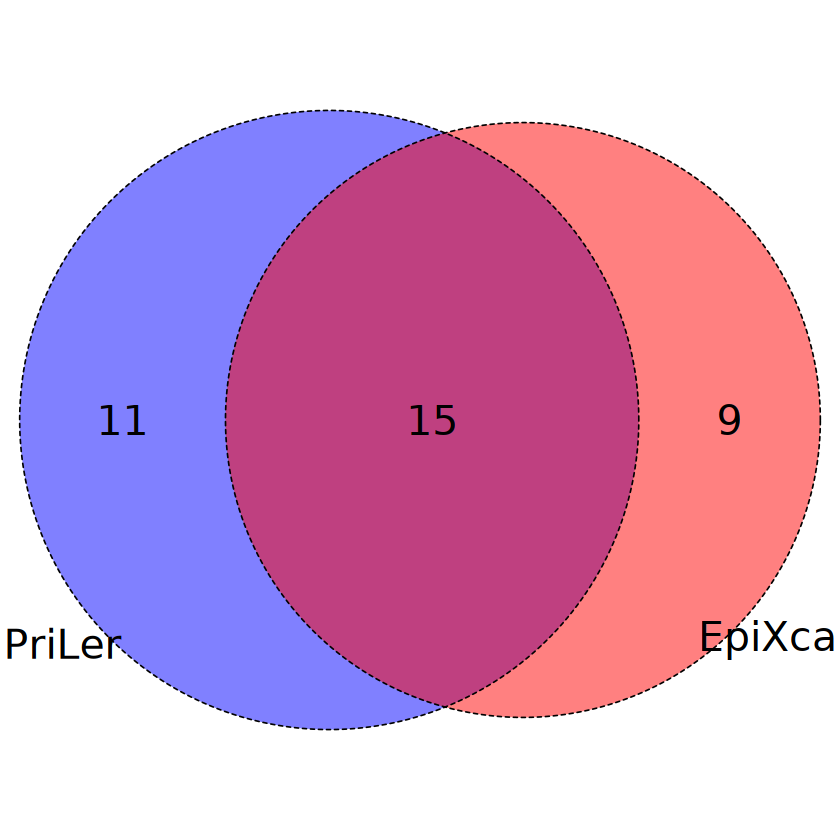

In [9]:
common_endo <- plot_intersection_endop(endop_tissue, endop_priler, outFold, pval_corr_thr = 0.1, 
    name_PRS = 'PriLer', name_tissue = 'EpiXcan', width_pl = 5, height_pl = 5)

In [16]:
common_endo

pheno_id,Field,meaning
<chr>,<chr>,<chr>
30630,Apolipoprotein A,NA
30640,Apolipoprotein B,NA
30690,Cholesterol,NA
30780,LDL direct,NA
30150,Eosinophill count,NA
30650,Aspartate aminotransferase,NA
30020,Haemoglobin concentration,NA
30250,Reticulocyte count,NA
30660,Direct bilirubin,NA


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] 0.9461538


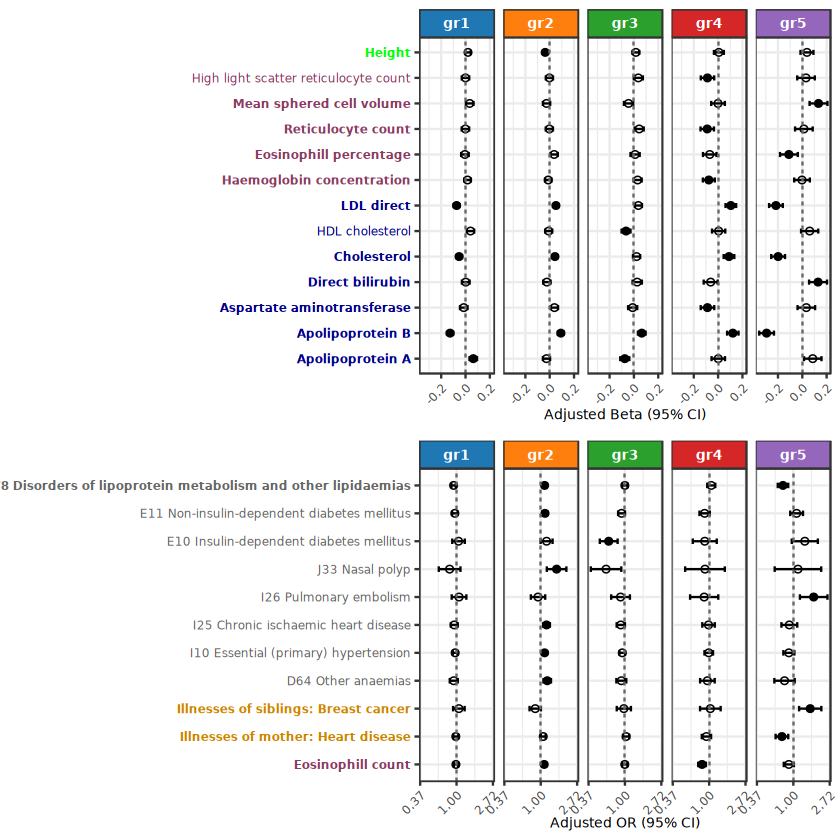

In [11]:
endopheno_forest_plot(
    common_endo = common_endo,
    colorFile, 
    endop_tissue, 
    pval_pheno = 0.0001,
    pval_corr_thr = 0.1, 
    outFold = outFold, 
    type_input = 'EpiXcan', 
    type_cluster = 'Cases')

[1] "N. common pheno for EpiXcan gr1 and PriLer gr5 = 247"
[1] "N. common pheno for EpiXcan gr2 and PriLer gr5 = 247"
[1] "N. common pheno for EpiXcan gr3 and PriLer gr5 = 247"
[1] "N. common pheno for EpiXcan gr4 and PriLer gr5 = 247"
[1] "N. common pheno for EpiXcan gr5 and PriLer gr1 = 247"
[1] "N. common pheno for EpiXcan gr5 and PriLer gr2 = 247"
[1] "N. common pheno for EpiXcan gr5 and PriLer gr3 = 247"
[1] "N. common pheno for EpiXcan gr5 and PriLer gr4 = 247"


,PriLer gr1,PriLer gr2,PriLer gr3,PriLer gr4,PriLer gr5
EpiXcan gr1,0.99940205,-0.47993951,-0.1888783,-0.39294617,0.06964634
EpiXcan gr2,-0.60878473,0.66200017,-0.2284033,0.23286367,-0.32286231
EpiXcan gr3,-0.32391547,-0.08799033,0.2771797,0.29713292,0.05159724
EpiXcan gr4,-0.03434146,-0.19870660,0.6588825,-0.15181834,-0.01795975
EpiXcan gr5,0.06841749,-0.30408058,0.0817761,-0.06713622,0.99991661


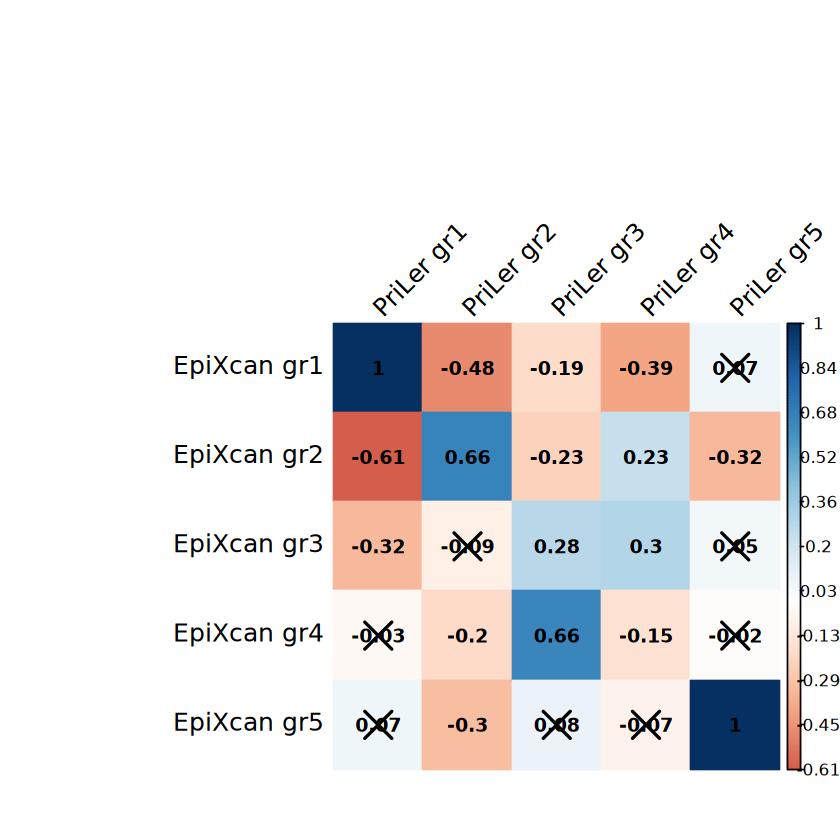

In [12]:
plot_corr_pheno(endop_tissue, endop_priler, outFold, name_comp_controls = "EpiXcan", width_pl = 6, height_pl = 6)

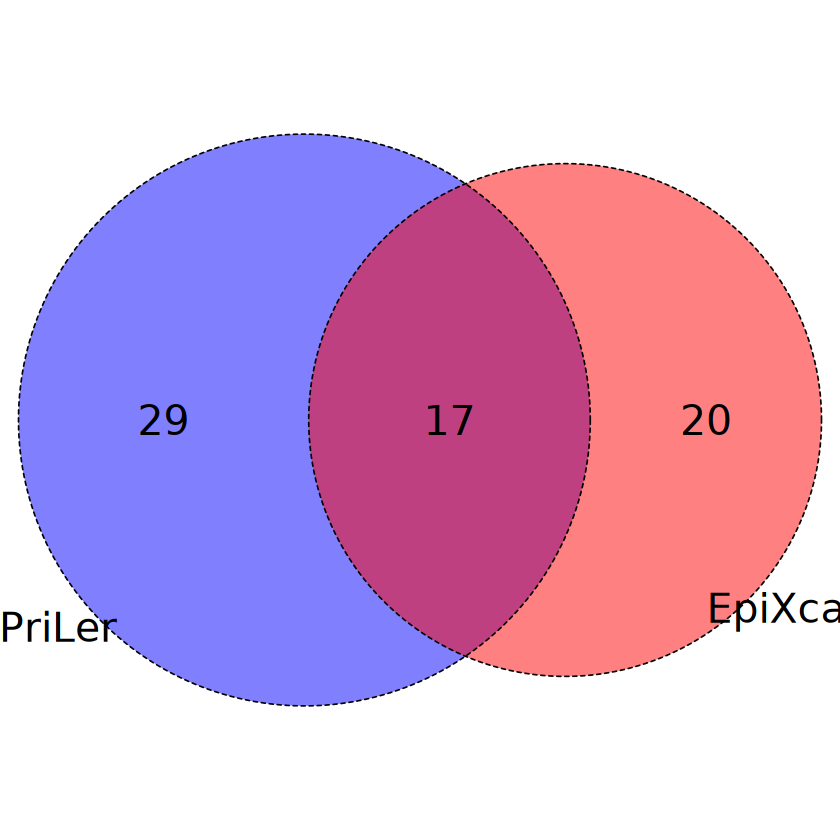

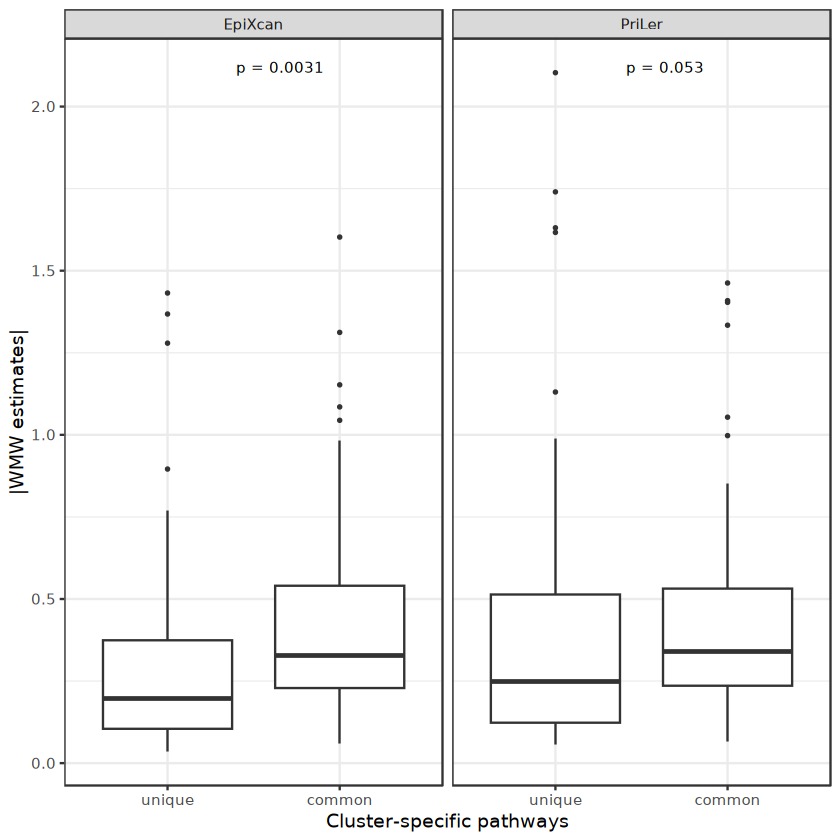

In [13]:
plot_intersection(path_tissue, path_priler, outFold, pval_corr_thr = 0.01, type_data = "Pathscores", name_comp_controls = "EpiXcan", width_pl = 3, height_pl = 3)

,PriLer gr1,PriLer gr2,PriLer gr3,PriLer gr4,PriLer gr5
EpiXcan gr1,0.9649569,-0.8070270,-0.9315065,-0.7897469,0.9574744
EpiXcan gr2,-0.8838427,0.8482739,0.8795117,0.5969028,-0.8749997
EpiXcan gr3,-0.6210899,0.3144614,0.5439976,0.7562518,-0.6324510
EpiXcan gr4,-0.8678014,0.7796009,0.8826405,0.6299051,-0.8563354
EpiXcan gr5,0.9545725,-0.7896184,-0.9236851,-0.7996974,0.9652849


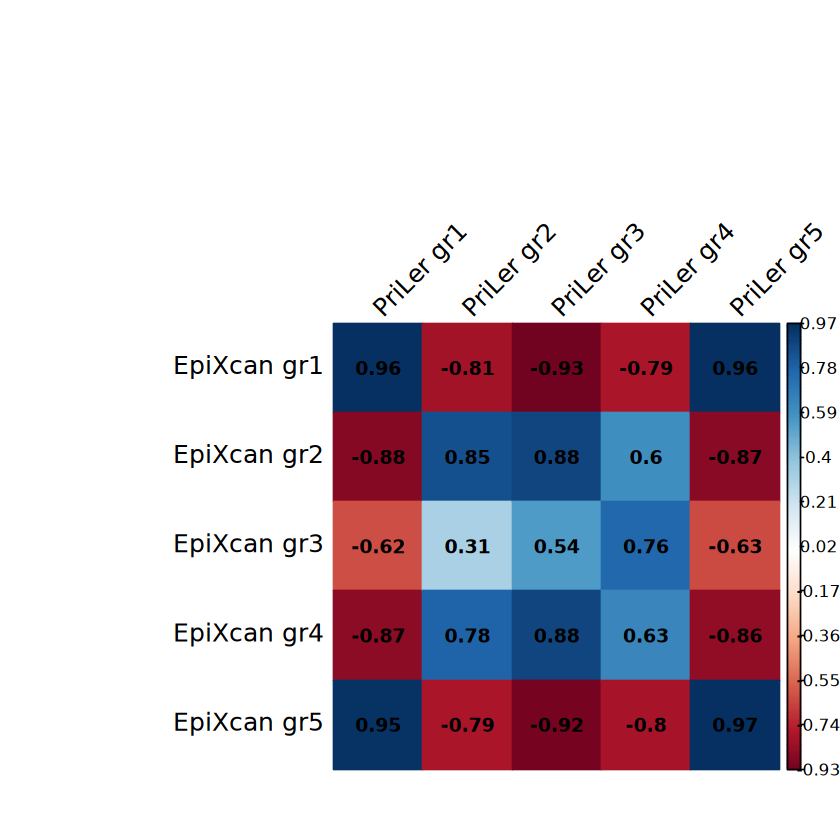

In [9]:
plot_corr_feat(path_tissue, path_priler, outFold, type_data = "Pathscores", name_comp_controls = "EpiXcan", width_pl = 6, height_pl = 6)

In [3]:
pts <- data.frame()

for (i in 1:100) {
  pts_ <- get(load(sprintf("data/priler_ukbb_liver/predictedTscores_splitGenes%s.RData", i)))
  
  pts <- rbind(pts, pts_)
}

In [4]:
head(pts)

,geneId,X3958967,X5903051,X2135894,X1136241,X2232191,X1464958,X3901966,X2316364,X3674451,⋯,X1227791,X2734099,X3419450,X4365009,X5251890,X3434927,X1909626,X3317476,X3749423,X4520275
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MRPL20,-195.59382,-393.7997,224.6049,-195.5406,147.8893,-258.3428,130.28834,-334.10925,-414.4531,⋯,-195.53416,227.6818,227.6256,-195.59560,-195.4286,232.2159,-248.1797,227.37003,655.86934,-412.1017
2,CDK11B,695.83688,237.0747,-379.1643,-213.3619,119.7958,390.6398,-76.66261,91.80028,236.9903,⋯,-62.36852,-379.1616,-379.0673,-59.80482,364.6288,-226.0206,-213.3045,-76.74494,-88.62899,-213.2325
3,TMEM52,122.32266,-387.0742,381.6176,381.8151,-448.4637,382.1916,-646.67202,122.52304,-391.5601,⋯,-132.35410,381.5009,381.9951,-132.72876,-137.0884,-392.0732,381.6582,-588.40635,-391.87707,381.6131
4,C1orf222,72.87703,-288.6465,390.2342,422.1159,-497.0590,390.9067,-568.70923,41.55223,-422.2804,⋯,-73.28189,449.9925,450.4712,-100.22580,-276.2710,-384.7359,422.0064,-476.68327,-422.50677,450.0852
5,MORN1,337.35827,-532.3717,-116.0741,319.5086,319.6435,-577.1240,321.31027,-147.87473,319.6229,⋯,-585.08550,319.7236,-131.8465,-586.32361,337.4433,337.4119,-123.5255,-551.77530,-141.41696,-124.1530
6,RP3-395M20.3,155.75350,-411.2381,-236.5986,180.3761,-187.8632,-117.7836,-175.93640,-507.81637,566.0273,⋯,-23.65117,392.4674,-209.6992,229.95778,-396.0887,-141.7271,112.4951,-507.49285,188.68175,-123.6765


In [5]:
nrow(pts)

[1] 2004

In [ ]:
ets <- data.frame()

for (i in 1:100) {
  ets_ <- get(load(sprintf("results/ukbb/predictedTscores_splitGenes%s.RData", i)))
  
  ets <- rbind(ets, ets_)
}

In [7]:
head(ets)

,geneId,X3958967,X5903051,X2135894,X1136241,X2232191,X1464958,X3901966,X2316364,X3674451,⋯,X1227791,X2734099,X3419450,X4365009,X5251890,X3434927,X1909626,X3317476,X3749423,X4520275
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,OIP5-AS1,335.6811,80.36852,663.8938,-249.735529,335.23942,-143.1663,419.49691,228.61889,47.26315,⋯,-250.07458,79.94042,-278.8237,79.97184,-142.96194,186.8301,-143.0370,293.7410,-217.1952,-249.8409
2,ZFYVE19,322.7496,322.90527,-129.8154,323.017121,-130.12926,-130.0328,322.86262,-129.75041,-583.06673,⋯,323.05114,323.20240,-129.9946,-130.17133,-132.33328,322.7700,-129.9797,322.5773,-129.9995,-130.1283
3,RP11-157P1.4,-210.2422,-145.24600,-210.3747,-210.136011,38.27866,-136.3726,589.84489,-274.84301,342.88280,⋯,278.60545,126.77890,-274.9394,897.62767,343.59488,343.5281,-136.6128,-275.0672,-210.3050,278.6305
4,RP11-195F19.9,-498.5035,174.16513,-262.0033,2.597513,109.75309,345.5661,-272.97340,-23.73524,-345.46813,⋯,-262.25951,-325.77891,-294.1867,-262.14525,-262.38775,281.2205,109.7600,-466.2144,-227.7105,174.2042
5,ZNF519,-187.4553,-225.21793,738.5825,371.000731,275.93540,-212.9793,82.62993,-241.91220,-402.31695,⋯,-86.56361,-124.49015,-270.7564,-141.73640,-97.13369,317.6132,267.9731,150.5878,149.4035,-236.8987
6,EBF4,-233.9788,256.01361,256.0848,-234.594932,-233.98454,256.3003,-234.18582,256.24808,255.95430,⋯,-234.16234,255.97923,256.2441,256.25057,256.15167,-724.0560,-724.5971,-234.0880,-723.9384,255.8145


In [8]:
nrow(ets)

[1] 1527

In [ ]:
pts <- pts[, colnames(ets)]

In [11]:
head(pts)

,geneId,X3958967,X5903051,X2135894,X1136241,X2232191,X1464958,X3901966,X2316364,X3674451,⋯,X1227791,X2734099,X3419450,X4365009,X5251890,X3434927,X1909626,X3317476,X3749423,X4520275
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MRPL20,-195.59382,-393.7997,224.6049,-195.5406,147.8893,-258.3428,130.28834,-334.10925,-414.4531,⋯,-195.53416,227.6818,227.6256,-195.59560,-195.4286,232.2159,-248.1797,227.37003,655.86934,-412.1017
2,CDK11B,695.83688,237.0747,-379.1643,-213.3619,119.7958,390.6398,-76.66261,91.80028,236.9903,⋯,-62.36852,-379.1616,-379.0673,-59.80482,364.6288,-226.0206,-213.3045,-76.74494,-88.62899,-213.2325
3,TMEM52,122.32266,-387.0742,381.6176,381.8151,-448.4637,382.1916,-646.67202,122.52304,-391.5601,⋯,-132.35410,381.5009,381.9951,-132.72876,-137.0884,-392.0732,381.6582,-588.40635,-391.87707,381.6131
4,C1orf222,72.87703,-288.6465,390.2342,422.1159,-497.0590,390.9067,-568.70923,41.55223,-422.2804,⋯,-73.28189,449.9925,450.4712,-100.22580,-276.2710,-384.7359,422.0064,-476.68327,-422.50677,450.0852
5,MORN1,337.35827,-532.3717,-116.0741,319.5086,319.6435,-577.1240,321.31027,-147.87473,319.6229,⋯,-585.08550,319.7236,-131.8465,-586.32361,337.4433,337.4119,-123.5255,-551.77530,-141.41696,-124.1530
6,RP3-395M20.3,155.75350,-411.2381,-236.5986,180.3761,-187.8632,-117.7836,-175.93640,-507.81637,566.0273,⋯,-23.65117,392.4674,-209.6992,229.95778,-396.0887,-141.7271,112.4951,-507.49285,188.68175,-123.6765


In [12]:
na.fail(head(pts))

ERROR: Error in na.fail.default(head(pts)): missing values in object


In [6]:
colnames(pts)[apply(head(pts), 2, anyNA)]

[1] "X4624781" "X5535166" "X4164791"

In [7]:
colnames(ets)[apply(head(ets), 2, anyNA)]

[1] "X4104093"

In [16]:
head(pts[, c('X4624781', 'X5535166', 'X4164791')])

,X4624781,X5535166,X4164791
,<dbl>,<dbl>,<dbl>
1,NA,NA,NA
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA
6,NA,NA,NA


In [17]:
head(ets[, c('X4624781', 'X5535166', 'X4164791')])

,X4624781,X5535166,X4164791
,<dbl>,<dbl>,<dbl>
1,-317.0717,228.6936,110.9279
2,-130.0363,322.8447,-130.7998
3,278.3118,-275.0307,-137.3911
4,-434.1972,-466.2640,142.2674
5,689.6123,-136.9668,-236.3919
6,-233.9830,-234.1194,255.4694


In [ ]:
pts <- select(pts, -c(X4624781, X5535166, X4164791, X4104093))
ets <- select(ets, -c(X4624781, X5535166, X4164791, X4104093))

In [ ]:
commong <- intersect(pts$geneId, ets$geneId)

In [ ]:
pts <- filter(pts, geneId %in% commong)
ets <- filter(ets, geneId %in% commong)

In [14]:
head(pts)

,X3958967,X5903051,X2135894,X1136241,X2232191,X1464958,X3901966,X2316364,X3674451,X4498514,⋯,X1227791,X2734099,X3419450,X4365009,X5251890,X3434927,X1909626,X3317476,X3749423,X4520275
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
515,141.0880,426.81982,-216.30035,207.3494,-223.6399,-7.857504,263.1458,-135.54445,-509.07269,258.23124,⋯,259.11757,304.88557,102.44955,-99.86018,-13.57132,373.2769,-55.91830,374.71650,20.38932,-81.09458
354,-479.0346,142.82420,-242.78838,218.5738,154.4598,-286.356700,-718.3975,-313.91779,-530.84141,88.09372,⋯,-300.45707,-194.94113,-83.90510,-395.87621,-195.19823,406.1659,360.42143,-433.18567,-182.13611,398.60818
632,-292.0832,-443.77724,306.14756,294.3900,147.5485,-430.672699,147.6015,-405.49660,-271.35867,-402.96482,⋯,-233.91858,-217.58160,-283.33254,-119.65786,122.19785,257.8362,24.57345,24.81988,-23.81118,-463.27320
692,-176.4300,-88.91183,66.45872,254.7068,180.8084,291.459657,341.8651,-433.25285,109.38548,181.32977,⋯,203.18831,273.71729,154.48753,595.40552,-431.35944,-725.3703,-110.73561,31.64224,50.73389,-142.66597
350,-413.5022,-238.78656,-399.88235,126.6379,-396.8791,-400.335243,-399.8535,50.77083,50.80898,-339.63264,⋯,47.92491,41.97224,56.41554,-97.04305,110.60410,-396.6078,50.74978,50.56200,-397.22368,526.83467
488,-434.4267,-329.18512,255.80572,-501.6970,121.2914,78.691631,365.4484,-283.25466,168.81565,-119.48862,⋯,647.73532,-161.50210,-120.48389,-366.88701,16.15141,-485.6907,-112.06837,548.84635,-76.11590,142.56779


In [15]:
head(ets)

,X3958967,X5903051,X2135894,X1136241,X2232191,X1464958,X3901966,X2316364,X3674451,X4498514,⋯,X1227791,X2734099,X3419450,X4365009,X5251890,X3434927,X1909626,X3317476,X3749423,X4520275
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,322.7496,322.9053,-129.81539,323.017121,-130.1293,-130.03276,322.86262,-129.75041,-583.06673,322.54431,⋯,323.05114,323.2024,-129.99460,-130.1713,-132.33328,322.7700,-129.9797,322.5773,-129.99948,-130.12828
2,-498.5035,174.1651,-262.00328,2.597513,109.7531,345.56609,-272.97340,-23.73524,-345.46813,140.44575,⋯,-262.25951,-325.7789,-294.18669,-262.1453,-262.38775,281.2205,109.7600,-466.2144,-227.71054,174.20424
3,-187.4553,-225.2179,738.58249,371.000731,275.9354,-212.97929,82.62993,-241.91220,-402.31695,-215.73915,⋯,-86.56361,-124.4901,-270.75637,-141.7364,-97.13369,317.6132,267.9731,150.5878,149.40349,-236.89871
4,-214.1451,-155.1500,152.58146,398.731453,-207.3266,362.05383,300.55107,-532.78382,-116.15733,-164.45953,⋯,-117.96039,399.3958,264.29120,302.5164,-534.56654,-676.3947,-63.1466,357.8229,214.91658,-61.01273
5,-389.7141,-224.8340,-419.26701,242.711612,-400.3560,-379.44733,-402.34406,74.60392,51.08709,-95.07897,⋯,71.37129,187.6604,76.61188,-232.3495,383.84823,-377.8118,-105.2703,74.6700,-433.19293,456.86644
6,-312.8626,-321.1132,47.85416,-321.542371,31.3819,26.04612,164.60529,-326.97413,47.43040,-140.51869,⋯,685.46965,-145.1967,-150.74866,-264.9076,82.07532,-327.0764,-134.6138,683.3579,-56.77523,31.20865


In [ ]:
pts <- pts[match(ets$geneId, pts$geneId), ]

In [ ]:
pts <- select(pts, -geneId)
ets <- select(ets, -geneId)

In [11]:
pryr::mem_used()

4.53 GB

In [12]:
head(pts)

,X3958967,X5903051,X2135894,X1136241,X2232191,X1464958,X3901966,X2316364,X3674451,X4498514,⋯,X1227791,X2734099,X3419450,X4365009,X5251890,X3434927,X1909626,X3317476,X3749423,X4520275
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
515,141.0880,426.81982,-216.30035,207.3494,-223.6399,-7.857504,263.1458,-135.54445,-509.07269,258.23124,⋯,259.11757,304.88557,102.44955,-99.86018,-13.57132,373.2769,-55.91830,374.71650,20.38932,-81.09458
354,-479.0346,142.82420,-242.78838,218.5738,154.4598,-286.356700,-718.3975,-313.91779,-530.84141,88.09372,⋯,-300.45707,-194.94113,-83.90510,-395.87621,-195.19823,406.1659,360.42143,-433.18567,-182.13611,398.60818
632,-292.0832,-443.77724,306.14756,294.3900,147.5485,-430.672699,147.6015,-405.49660,-271.35867,-402.96482,⋯,-233.91858,-217.58160,-283.33254,-119.65786,122.19785,257.8362,24.57345,24.81988,-23.81118,-463.27320
692,-176.4300,-88.91183,66.45872,254.7068,180.8084,291.459657,341.8651,-433.25285,109.38548,181.32977,⋯,203.18831,273.71729,154.48753,595.40552,-431.35944,-725.3703,-110.73561,31.64224,50.73389,-142.66597
350,-413.5022,-238.78656,-399.88235,126.6379,-396.8791,-400.335243,-399.8535,50.77083,50.80898,-339.63264,⋯,47.92491,41.97224,56.41554,-97.04305,110.60410,-396.6078,50.74978,50.56200,-397.22368,526.83467
488,-434.4267,-329.18512,255.80572,-501.6970,121.2914,78.691631,365.4484,-283.25466,168.81565,-119.48862,⋯,647.73532,-161.50210,-120.48389,-366.88701,16.15141,-485.6907,-112.06837,548.84635,-76.11590,142.56779


In [22]:
cor(as.numeric(pts[1, ]), as.numeric(ets[1, ]))

[1] 0.8786909

In [ ]:
cpts <- pts - rowMeans(pts)
cets <- ets - rowMeans(ets)
spts <- sqrt(rowMeans(cpts^2))
sets <- sqrt(rowMeans(cets^2))

cr <- rowMeans(cpts * cets) / (spts * sets)

In [24]:
head(cr)

515       354       632       692       350       488 
0.8786909 0.8028627 0.8288993 0.7561565 0.9683875 0.9435754

In [14]:
median(cr)

[1] 0.9074687

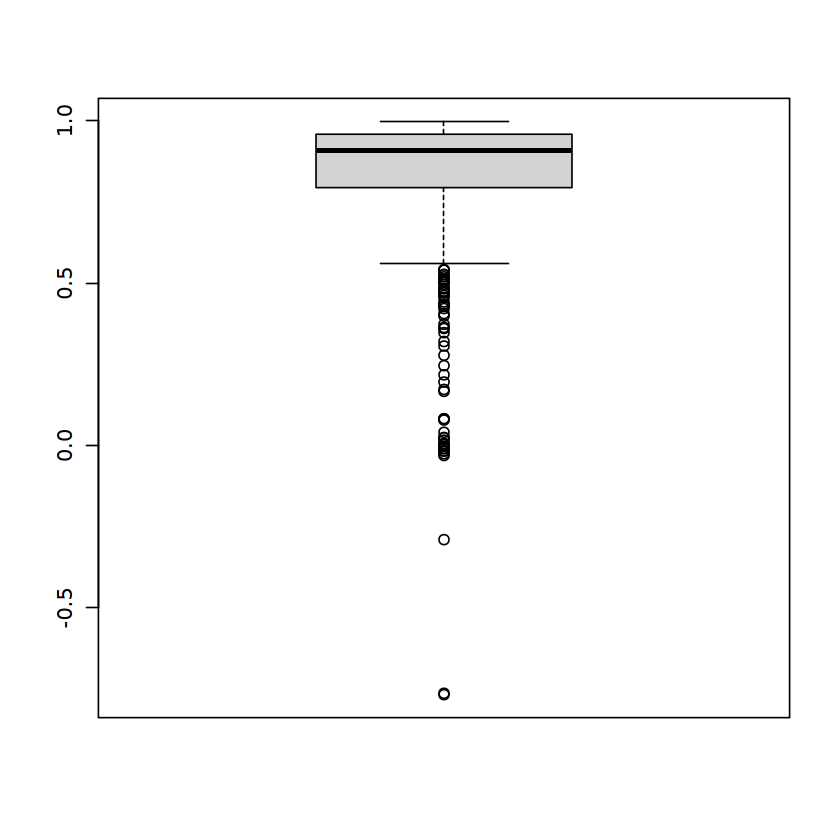

In [25]:
boxplot(cr)

In [4]:
load_res <- function(fold, tissue){
  
    df <- read.delim(sprintf('%s/resPrior_regEval_allchr.txt', fold), h=T, stringsAsFactors = F, sep = '\t')
    df$tissue <- tissue
    df$n_regSNPs <- NA
    
    # reg-SNPs per gene, regardless category
    coef <- get(load(sprintf('%s/resPrior_regCoeffSnps_allchr.RData', fold)))
    for(id_chr in 1:length(coef)){
        n_snps <- colSums(coef[[id_chr]]!=0)
        df$n_regSNPs[df$chrom == paste0('chr', id_chr)] <- n_snps
    }
    df$n_regSNPs[is.na(df$dev)] <- NA
    
    return(df)
}

In [9]:
df <- load_res("/scratch/tmp/dolgalev/castom-igex-revision/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/Liver/200kb/CAD_GWAS_bin5e-2", tissue = 'Liver')

In [10]:
colnames(df)

[1] "type"                       "chrom"                     
 [3] "TSS_start"                  "TSS_end"                   
 [5] "name"                       "start_position"            
 [7] "end_position"               "ensembl_gene_id"           
 [9] "external_gene_name"         "train_dev"                 
[11] "train_dev_geno"             "train_dev_cov"             
[13] "train_dev_geno_cov"         "train_cor"                 
[15] "train_cor_pvalue"           "train_cor_noadj"           
[17] "train_cor_noadj_pvalue"     "test_dev"                  
[19] "test_dev_geno"              "test_dev_cov"              
[21] "test_dev_geno_cov"          "test_cor"                  
[23] "test_cor_pvalue"            "test_cor_noadj"            
[25] "test_cor_noadj_pvalue"      "test_comb_cor"             
[27] "test_comb_cor_pvalue"       "test_comb_cor_noadj"       
[29] "test_comb_cor_noadj_pvalue" "dev"                       
[31] "dev_geno"                   "dev_cov"                   
[33] "dev_geno_cov"               "cor"                       
[35] "cor_pval"                   "cor_noadj"                 
[37] "cor_noadj_pval"             "tissue"                    
[39] "n_regSNPs"

In [11]:
df_gene <- df

In [3]:
load_epixcan_model <- function(path) {
  ex <- DBI::dbConnect(RSQLite::SQLite(), path)
  
  ex <- DBI::dbReadTable(ex, "extra_full")
  
  return(ex)
}

In [4]:
epi <- DBI::dbConnect(RSQLite::SQLite(), "/cloud/wwu1/h_fungenpsy/AGZiller_data/EpiXcan/PredictDB/GTEx_Liv_EpiX_alpha0.5_window1e6_filtered.db")

In [5]:
DBI::dbListTables(epi)

[1] "construction" "extra"        "extra_full"   "sample_info"  "weights"

In [6]:
epif <- DBI::dbReadTable(epi, "extra_full")

In [7]:
colnames(epif)

[1] "gene"                  "genename"              "gene_type"            
 [4] "alpha"                 "n_snps_in_window"      "n.snps.in.model"      
 [7] "adj_R2"                "pvalue_all"            "RMSE_avg"             
[10] "test_R2_avg"           "test_R2_sd"            "cv_R2_avg"            
[13] "cv_R2_sd"              "in_sample_R2"          "nested_cv_fisher_pval"
[16] "rho_avg"               "rho_se"                "rho_zscore"           
[19] "pred.perf.R2"          "pred.perf.pval"        "pred.perf.qval"

In [12]:
filter(epif, adj_R2 >= 0.01)

gene,genename,gene_type,alpha,n_snps_in_window,n.snps.in.model,adj_R2,pvalue_all,RMSE_avg,test_R2_avg,⋯,cv_R2_avg,cv_R2_sd,in_sample_R2,nested_cv_fisher_pval,rho_avg,rho_se,rho_zscore,pred.perf.R2,pred.perf.pval,pred.perf.qval
<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000227232,WASH7P,unprocessed_pseudogene,0.5,595,4,0.08370197,9.866814e-05,0.9894490,-0.052934621,⋯,0.0202244319,0.04002283,0.040918607,9.171844e-01,-0.05322967,0.08150493,-0.5744036,0.0028333975,5.656947e-01,1.000000e+00
ENSG00000229344,MTCO2P12,unprocessed_pseudogene,0.5,2015,1,0.08094752,6.067335e-04,0.9623440,-0.016160928,⋯,0.0004836119,0.02759348,0.017291981,1.963786e-01,0.04508448,0.10081197,0.4919257,0.0020326106,6.227719e-01,1.000000e+00
ENSG00000240409,MTATP8P1,unprocessed_pseudogene,0.5,2015,1,0.05591679,3.901845e-03,0.9601896,-0.019823970,⋯,0.0001213214,0.03034352,0.004550618,1.172990e-01,-0.06195510,0.13853582,-0.6869607,0.0038384344,4.921075e-01,1.000000e+00
ENSG00000248527,MTATP6P1,unprocessed_pseudogene,0.5,2015,2,0.05940528,1.744149e-03,1.0047030,-0.025046321,⋯,0.0115762422,0.02797509,0.005350388,3.093827e-01,-0.03223730,0.07208479,-0.3487480,0.0010392435,7.272785e-01,1.000000e+00
ENSG00000237491,AL669831.5,lincRNA,0.5,2237,25,0.21967964,1.509903e-14,0.9945046,0.016444949,⋯,0.0070365121,0.04033256,0.171437058,8.341720e-01,0.08145033,0.12815991,0.8934869,0.0066341569,3.715965e-01,1.000000e+00
ENSG00000225880,LINC00115,lincRNA,0.5,2260,6,0.22715360,4.392073e-10,0.7669865,0.142841823,⋯,0.1482339745,0.21135034,0.210254448,1.750913e-07,0.45665553,0.24119980,5.7018980,0.2085342712,1.184807e-08,2.877003e-07
ENSG00000187634,SAMD11,protein_coding,0.5,2475,10,0.15848293,1.327438e-08,0.9351328,0.019453446,⋯,0.0302286234,0.06773334,0.123223662,2.528482e-02,0.24550992,0.16289897,2.7432181,0.0602751222,6.084027e-03,4.283266e-02
ENSG00000188976,NOC2L,protein_coding,0.5,2516,4,0.15231500,5.480755e-07,0.8990610,0.010404676,⋯,0.0451092629,0.10324741,0.099631819,2.782260e-02,0.28958589,0.10777446,3.2311712,0.0838599851,1.232841e-03,1.036680e-02
ENSG00000187961,KLHL17,protein_coding,0.5,2545,2,0.12258095,1.556930e-05,0.9862269,-0.023251315,⋯,0.0107936450,0.04542291,0.044182804,4.173566e-01,0.05509775,0.16673043,0.6077300,0.0030357622,5.433666e-01,1.000000e+00


In [17]:
epipri <- merge(select(df_gene, ensembl_gene_id, test_comb_cor, test_cor, dev_geno, test_dev_geno, n_regSNPs), select(epif, gene, n.snps.in.model, pred.perf.R2, cv_R2_avg, adj_R2, test_R2_avg), by.x = "ensembl_gene_id", by.y = "gene", all.)

In [18]:
epipri$test_cor2 <- epipri$test_cor ** 2
epipri$test_comb_cor2 <- epipri$test_comb_cor ** 2

In [19]:
pdx <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Liver_compare_PriLer_prediXcan_v6p.txt", header = TRUE)

In [20]:
pdx7 <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Liver_compare_PriLer_prediXcan_v7.txt", header = TRUE)

In [21]:
pdx7[pdx7$external_gene_name == "RABL2B", c("external_gene_name", "test_cor")]

,external_gene_name,test_cor
,<chr>,<dbl>
3192,RABL2B,0.1894726


In [22]:
pdx[pdx$external_gene_name == "RABL2B", c("external_gene_name", "test_cor")]

,external_gene_name,test_cor
,<chr>,<dbl>
2470,RABL2B,0.1894726


In [23]:
twas <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Liver_compare_PriLer_TWAS_v6p.txt", header = TRUE)

In [24]:
x <- merge(
  select(epipri, ensembl_gene_id, test_cor2, test_comb_cor2, cv_R2_avg),
  merge(
    select(pdx, ensembl_gene_id, pred.perf.R2),
    select(twas, ensembl_gene_id, best.r2),
    all = TRUE
  ),
  all = TRUE
)

In [27]:
select(x, test_comb_cor2, pred.perf.R2) %>% na.omit() %>% transmute(adv = test_comb_cor2 > pred.perf.R2) %>% {print(nrow(.)); table(.) / nrow(.)}

[1] 1977


adv
    FALSE      TRUE 
0.4522003 0.5477997 

In [49]:
select(x, test_comb_cor2, pred.perf.R2) %>% na.omit() %>% {wilcox.test(x = .$test_comb_cor2, y = .$pred.perf.R2, paired = TRUE, alternative = "greater")}


	Wilcoxon signed rank test with continuity correction

data:  .$test_comb_cor2 and .$pred.perf.R2
V = 1229251, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0


In [29]:
select(x, test_comb_cor2, best.r2) %>% na.omit() %>% transmute(adv = test_comb_cor2 > best.r2) %>% {print(nrow(.)); table(.) / nrow(.)}

[1] 605


adv
    FALSE      TRUE 
0.2247934 0.7752066 

In [50]:
select(x, test_comb_cor2, best.r2) %>% na.omit() %>% {wilcox.test(x = .$test_comb_cor2, y = .$best.r2, paired = TRUE, alternative = "greater")}


	Wilcoxon signed rank test with continuity correction

data:  .$test_comb_cor2 and .$best.r2
V = 155076, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0


In [38]:
select(x, test_cor2, cv_R2_avg) %>% na.omit() %>% transmute(adv = test_cor2 > cv_R2_avg) %>% {print(nrow(.)); table(.) / nrow(.)}

[1] 10469


adv
    FALSE      TRUE 
0.5760818 0.4239182 

In [58]:
select(x, test_cor2, cv_R2_avg) %>% na.omit() %>% {wilcox.test(x = .$test_cor2, y = .$cv_R2_avg, paired = TRUE, alternative = "less")}


	Wilcoxon signed rank test with continuity correction

data:  .$test_cor2 and .$cv_R2_avg
V = 20769785, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0


In [52]:
col_priler = "#78add2"
col_twas_6p = "#ffb26e"
col_predixcan_6p = "#e67d7e"
col_epixcan = "#78d2ad"

comp <- function(df, r_priler, r_other, name_other, col_other) {
  r_priler <- rlang::sym(r_priler)
  r_other <- rlang::sym(r_other)
  
  df <- df %>%
    select(!!r_priler, !!r_other) %>%
    na.omit()
  
  #return(df)
  
  g1 <- ggplot(df, aes(x = !!r_priler, y = !!r_other)) +#, fill = !!r_priler > !!r_other)) +
    #geom_hdr(aes(fill = after_stat(probs)), method = "kde", probs = c(0.99, 0.95, 0.90, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3), alpha = 1, n = 10) + 
    geom_abline(intercept = 0, slope = 1, color = "gray") + 
    geom_hdr_points(probs = c(0.98, 0.9, 0.8, 0.5), n = 100) +
    geom_smooth(method = "lm", color = "red") + 
    #stat_density_2d(aes(fill = after_stat(level)), geom = "polygon", contour_var = "ndensity", n = 100 , bins = 50) +          
    #geom_point(alpha = 0.75) +
    scale_x_continuous(limits = c(0, 0.8)) +
    scale_y_continuous(limits = c(0, 0.8)) +
    #scale_fill_manual(values = c(col_other, col_priler)) +
    labs(x = TeX('CV $corr^2$ (PriLer)'), y = c(TeX(sprintf('CV $corr^2$ (%s)', name_other))), color = "Probability") +
    theme_classic()
    
  ct <- df %>%
    transmute(r_comp = !!r_priler > !!r_other) %>%
    count(r_comp) %>%
    arrange(desc(r_comp))
  
  ct$prop <- c(paste0(round(ct$n[1] / sum(ct$n) * 100, 1), "%"), NA)
  
  g2 <- ggplot(ct, aes(x = "idklol", y = n, fill = r_comp)) + 
    geom_col() + 
    geom_text(aes(y = n, label = prop), hjust = 1.1) + 
    coord_flip() +
    scale_fill_manual(labels = parse(text = c(TeX(paste0('PriLer $<$', name_other)), TeX(paste0('PriLer $\\geq$', name_other)))), values = rev(c(col_priler, col_other)))+
    scale_x_discrete(labels=parse(text = c(TeX('CV $corr^2$')))) +
    labs(x = "", y = TeX('n. genes')) +
    theme_classic() + 
    theme(
      legend.position = 'bottom',
      legend.title = element_blank(), legend.direction  = 'vertical', 
      plot.title = element_text(hjust = 0.5), 
      axis.text = element_text(size = 12), axis.title = element_text(size = 10), 
      axis.text.x = element_text(angle = 0, vjust = 1, hjust = 1)
  )
  
  #g <- patchwork::wrap_plots(g1, g2, ncol = 1, heights = c(5, 1))
  
  return(g1)
}

In [53]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)

r2_comp <- patchwork::wrap_plots(
  comp(x, "test_cor2", "cv_R2_avg", "EpiXcan v7", col_epixcan), 
  comp(x, "test_comb_cor2", "pred.perf.R2", "PrediXcan v6p", col_predixcan_6p), 
  comp(x, "test_comb_cor2", "best.r2", "TWAS v6p", col_twas_6p), 
  ncol = 3,
  guides = "collect"
)

In [31]:
ggsave("results/r2_comp_priler_epixcan_predixcan_twas.pdf", width = 10, height = 3, dpi = 300)

Warning message:
“Removed 1 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 33 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 33 rows containing non-finite values (`stat_smooth()`).”


In [59]:
pl_liv <- load_res("/scratch/tmp/dolgalev/castom-igex-revision/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/Liver/200kb/CAD_GWAS_bin5e-2", tissue = 'GTEx_Liver')
pl_aao <- load_res("/scratch/tmp/dolgalev/castom-igex-revision/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/Artery_Aorta/200kb/CAD_GWAS_bin5e-2", tissue = 'GTEx_Artery_Aorta')
pl_avo <- load_res("/scratch/tmp/dolgalev/castom-igex-revision/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/Adipose_Visceral_Omentum/200kb/CAD_GWAS_bin5e-2", tissue = 'GTEx_Adipose_Visceral_Omentum')
pl_cmc <- load_res("/scratch/tmp/dolgalev/castom-igex-revision/PriLer_PROJECT_CMC/OUTPUT_SCZ-PGC_SCRIPTS_v2/train_All/200kb/PGC_GWAS_bin1e-2", tissue = 'CMC_DPLC')

In [60]:
colnames(pl_liv)

[1] "type"                       "chrom"                     
 [3] "TSS_start"                  "TSS_end"                   
 [5] "name"                       "start_position"            
 [7] "end_position"               "ensembl_gene_id"           
 [9] "external_gene_name"         "train_dev"                 
[11] "train_dev_geno"             "train_dev_cov"             
[13] "train_dev_geno_cov"         "train_cor"                 
[15] "train_cor_pvalue"           "train_cor_noadj"           
[17] "train_cor_noadj_pvalue"     "test_dev"                  
[19] "test_dev_geno"              "test_dev_cov"              
[21] "test_dev_geno_cov"          "test_cor"                  
[23] "test_cor_pvalue"            "test_cor_noadj"            
[25] "test_cor_noadj_pvalue"      "test_comb_cor"             
[27] "test_comb_cor_pvalue"       "test_comb_cor_noadj"       
[29] "test_comb_cor_noadj_pvalue" "dev"                       
[31] "dev_geno"                   "dev_cov"                   
[33] "dev_geno_cov"               "cor"                       
[35] "cor_pval"                   "cor_noadj"                 
[37] "cor_noadj_pval"             "tissue"                    
[39] "n_regSNPs"

In [61]:
ex_liv <- load_epixcan_model("/cloud/wwu1/h_fungenpsy/AGZiller_data/EpiXcan/PredictDB/GTEx_Liv_EpiX_alpha0.5_window1e6_filtered.db")
ex_aao <- load_epixcan_model("/cloud/wwu1/h_fungenpsy/AGZiller_data/EpiXcan/PredictDB/GTEx_Aor_EpiX_alpha0.5_window1e6_filtered.db")
ex_avo <- load_epixcan_model("/cloud/wwu1/h_fungenpsy/AGZiller_data/EpiXcan/PredictDB/GTEx_VAF_EpiX_alpha0.5_window1e6_filtered.db")
ex_cmc <- load_epixcan_model("/cloud/wwu1/h_fungenpsy/AGZiller_data/EpiXcan/PredictDB/CMC467_EpiX_alpha0.5_window1e6_filtered.db")

In [62]:
colnames(ex_liv)

[1] "gene"                  "genename"              "gene_type"            
 [4] "alpha"                 "n_snps_in_window"      "n.snps.in.model"      
 [7] "adj_R2"                "pvalue_all"            "RMSE_avg"             
[10] "test_R2_avg"           "test_R2_sd"            "cv_R2_avg"            
[13] "cv_R2_sd"              "in_sample_R2"          "nested_cv_fisher_pval"
[16] "rho_avg"               "rho_se"                "rho_zscore"           
[19] "pred.perf.R2"          "pred.perf.pval"        "pred.perf.qval"

In [63]:
px_liv <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Liver_compare_PriLer_prediXcan_v6p.txt", header = TRUE)
px_aao <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Artery_Aorta_compare_PriLer_prediXcan_v6p.txt", header = TRUE)
px_avo <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Adipose_Visceral_Omentum_compare_PriLer_prediXcan_v6p.txt", header = TRUE)
px_cmc <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_CMC/compare_PriLer_prediXcan.txt", header = TRUE)

In [64]:
colnames(px_liv)

[1] "external_gene_name"   "type"                 "chrom"               
 [4] "TSS_start"            "TSS_end"              "name"                
 [7] "start_position"       "end_position"         "ensembl_gene_id"     
[10] "train_dev"            "train_dev_geno"       "train_dev_cov"       
[13] "train_dev_geno_cov"   "train_cor"            "train_cor_pvalue"    
[16] "test_dev"             "test_dev_geno"        "test_dev_cov"        
[19] "test_dev_geno_cov"    "test_cor"             "test_cor_pvalue"     
[22] "test_comb_cor"        "test_comb_cor_pvalue" "dev"                 
[25] "dev_geno"             "dev_cov"              "dev_geno_cov"        
[28] "cor"                  "cor_pval"             "n_snps"              
[31] "n_snps_gene_window"   "gene"                 "pred.perf.R2"        
[34] "n.snps.in.model"      "pred.perf.pval"       "pred.perf.qval"

In [65]:
tw_liv <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Liver_compare_PriLer_TWAS_v6p.txt", header = TRUE)
tw_aao <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Artery_Aorta_compare_PriLer_TWAS_v6p.txt", header = TRUE)
tw_avo <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_GTEx/Adipose_Visceral_Omentum_compare_PriLer_TWAS_v6p.txt", header = TRUE)
tw_cmc <- read.table("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/compare_TWAS_prediXcan/res_CMC/compare_PriLer_TWAS.txt", header = TRUE)

In [66]:
colnames(tw_liv)

[1] "external_gene_name"   "type"                 "chrom"               
 [4] "TSS_start"            "TSS_end"              "name"                
 [7] "start_position"       "end_position"         "ensembl_gene_id"     
[10] "train_dev"            "train_dev_geno"       "train_dev_cov"       
[13] "train_dev_geno_cov"   "train_cor"            "train_cor_pvalue"    
[16] "test_dev"             "test_dev_geno"        "test_dev_cov"        
[19] "test_dev_geno_cov"    "test_cor"             "test_cor_pvalue"     
[22] "test_comb_cor"        "test_comb_cor_pvalue" "dev"                 
[25] "dev_geno"             "dev_cov"              "dev_geno_cov"        
[28] "cor"                  "cor_pval"             "n_snps"              
[31] "n_snps_gene_window"   "ensemble_gene_id"     "nsnps"               
[34] "hsq"                  "hsq.se"               "hsq.pv"              
[37] "blup.r2"              "lasso.r2"             "enet.r2"             
[40] "bslmm.r2"             "blup.pv"              "lasso.pv"            
[43] "enet.pv"              "bslmm.pv"             "blup.nsnps"          
[46] "lasso.nsnps"          "enet.nsnps"           "bslmm.nsnps"         
[49] "best.r2"              "best.pv"              "best.nsnps"          
[52] "ensemble_gene_id_new"

In [67]:
tw_liv %>% select(ensemble_gene_id, ensemble_gene_id_new) %>% head()

,ensemble_gene_id,ensemble_gene_id_new
,<chr>,<chr>
1,ENSG00000225972.1,ENSG00000225972
2,ENSG00000237973.1,ENSG00000237973
3,ENSG00000225880.4,ENSG00000225880
4,ENSG00000116198.8,ENSG00000116198
5,ENSG00000131697.13,ENSG00000131697
6,ENSG00000142655.8,ENSG00000142655


In [68]:
liv_snps <- select(pl_liv, ensembl_gene_id, n_regSNPs) %>%
  merge(
    select(ex_liv, gene, n_snps_in_window, n.snps.in.model) %>% 
      rename(n.snps.in.model.ex = n.snps.in.model, n_snps_in_window.ex = n_snps_in_window), 
    by.x = "ensembl_gene_id", by.y = "gene", all = TRUE
  ) %>%
  merge(
    select(px_liv, ensembl_gene_id, n.snps.in.model) %>% 
      rename(n.snps.in.model.px = n.snps.in.model), 
    by.y = "ensembl_gene_id", all = TRUE
  ) %>%
  merge(
    select(tw_liv, ensemble_gene_id_new, n_snps_gene_window, best.nsnps) %>% 
      rename(n_snps_gene_window.tw = n_snps_gene_window, best.nsnps.tw = best.nsnps), 
    by.x = "ensembl_gene_id", by.y = "ensemble_gene_id_new", all = TRUE
  )

In [76]:
select(liv_snps, n_regSNPs, n.snps.in.model.px) %>% na.omit() %>% transmute(adv = n_regSNPs > n.snps.in.model.px) %>% {print(nrow(.)); table(.) / nrow(.)}

[1] 2463


adv
    FALSE      TRUE 
0.6252538 0.3747462 

In [71]:
select(liv_snps, n_regSNPs, best.nsnps.tw) %>% na.omit() %>% transmute(adv = n_regSNPs > best.nsnps.tw) %>% {print(nrow(.)); table(.) / nrow(.)}

[1] 746


adv
    FALSE      TRUE 
0.2600536 0.7399464 

In [73]:
select(liv_snps, n_regSNPs, n.snps.in.model.ex) %>% na.omit() %>% transmute(adv = n_regSNPs > n.snps.in.model.ex) %>% {print(nrow(.)); table(.) / nrow(.)}

[1] 13453


adv
    FALSE      TRUE 
0.3996135 0.6003865 

In [54]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)


liv_snps <- select(pl_liv, ensembl_gene_id, n_regSNPs) %>%
  merge(
    select(ex_liv, gene, n_snps_in_window, n.snps.in.model) %>% 
      rename(n.snps.in.model.ex = n.snps.in.model, n_snps_in_window.ex = n_snps_in_window), 
    by.x = "ensembl_gene_id", by.y = "gene", all = TRUE
  ) %>%
  merge(
    select(px_liv, ensembl_gene_id, n.snps.in.model) %>% 
      rename(n.snps.in.model.px = n.snps.in.model), 
    by.y = "ensembl_gene_id", all = TRUE
  ) %>%
  merge(
    select(tw_liv, ensemble_gene_id_new, n_snps_gene_window, best.nsnps) %>% 
      rename(n_snps_gene_window.tw = n_snps_gene_window, best.nsnps.tw = best.nsnps), 
    by.x = "ensembl_gene_id", by.y = "ensemble_gene_id_new", all = TRUE
  )


snps_comp <- patchwork::wrap_plots(
  ggplot(liv_snps, aes(x = n_regSNPs, y = n.snps.in.model.ex)) + 
    geom_abline(intercept = 0, slope = 1, color = "gray") + 
    geom_hdr_points(probs = c(0.98, 0.9, 0.8, 0.5), n = 100) + 
    scale_x_continuous(limits = c(0, 400)) + 
    scale_y_continuous(limits = c(0, 400)) +
    labs(x = TeX('n. reg-SNPs (PriLer)'), y = TeX('n. reg-SNPs (EpiXcan)'), color = "Probability") +
    theme_classic(),
  
  ggplot(liv_snps, aes(x = n_regSNPs, y = n.snps.in.model.px)) + 
    geom_abline(intercept = 0, slope = 1, color = "gray") + 
    geom_hdr_points(probs = c(0.98, 0.9, 0.8, 0.5), n = 100) + 
    scale_x_continuous(limits = c(0, 400)) + 
    scale_y_continuous(limits = c(0, 400)) +
    labs(x = TeX('n. reg-SNPs (PriLer)'), y = TeX('n. reg-SNPs (PrediXcan)'), color = "Probability") +
    theme_classic(),
  
  ggplot(liv_snps, aes(x = n_regSNPs, y = best.nsnps.tw)) + 
    geom_abline(intercept = 0, slope = 1, color = "gray") + 
    geom_hdr_points(probs = c(0.98, 0.9, 0.8, 0.5), n = 100) + 
    scale_x_continuous(limits = c(0, 400)) + 
    scale_y_continuous(limits = c(0, 400)) +
    labs(x = TeX('n. reg-SNPs (PriLer)'), y = TeX('n. reg-SNPs (TWAS)'), color = "Probability") +
    theme_classic(),
  
  ncol = 3,
  guides = "collect"
)

Warning message:
“Removed 1 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 33 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 33 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9256 rows containing non-finite values (`stat_hdr_points()`).”
Warning message:
“Removed 20246 rows containing non-finite values (`stat_hdr_points()`).”
Warning message:
“Removed 21963 rows containing non-finite values (`stat_hdr_points()`).”


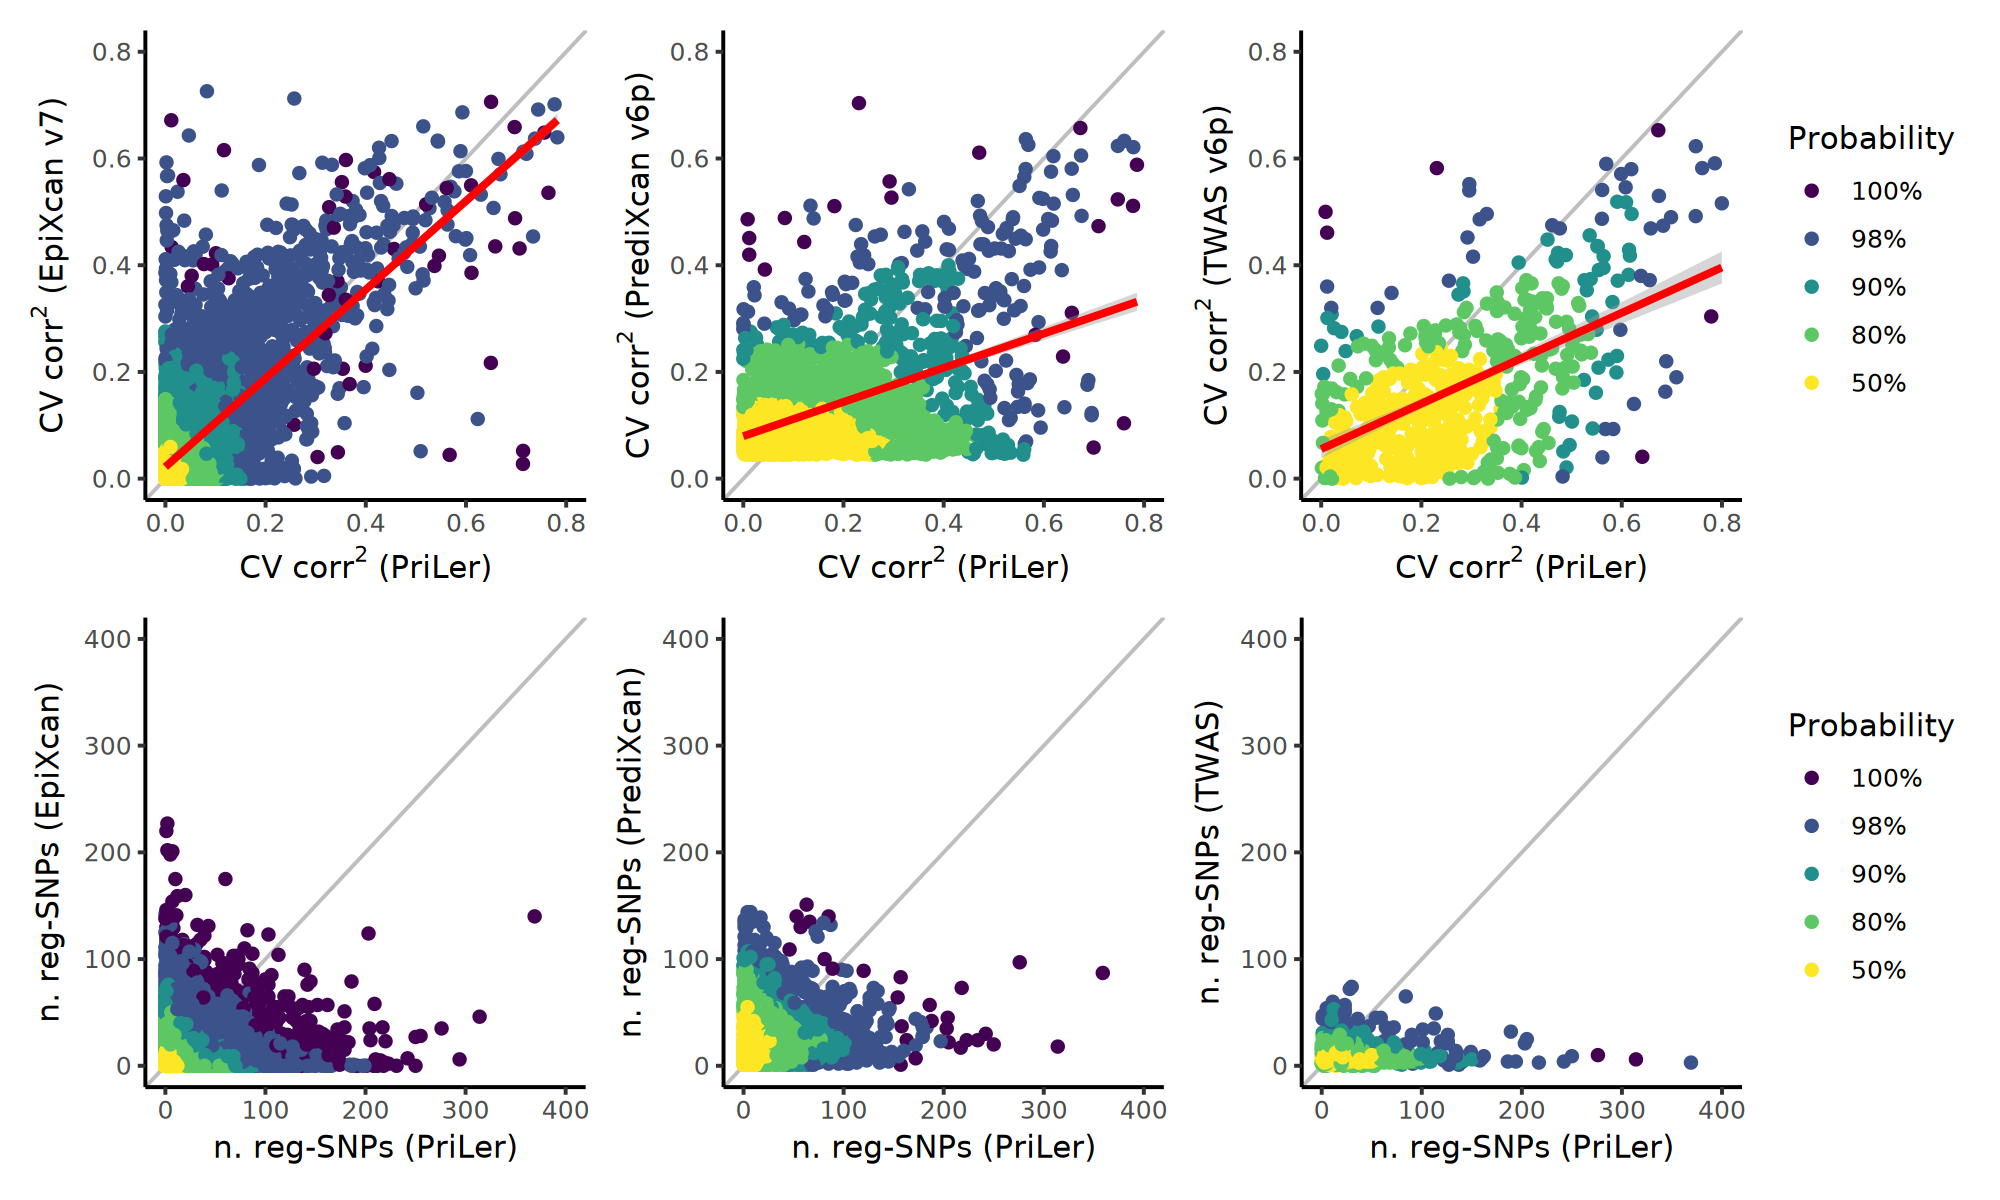

In [56]:
options(repr.plot.height = 6)

r2_comp / snps_comp + patchwork::plot_layout(guides = "collect")

In [57]:
ggsave("results/comp_cor_nsnps_priler_others.pdf", height = 6, width = 10, dpi = 300)

Warning message:
“Removed 1 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 33 rows containing non-finite values (`stat_hdr_points()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 33 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 9256 rows containing non-finite values (`stat_hdr_points()`).”
Warning message:
“Removed 20246 rows containing non-finite values (`stat_hdr_points()`).”
Warning message:
“Removed 21963 rows containing non-finite values (`stat_hdr_points()`).”
